# Fine-tuning CLIP

This notebook is for fine-tuning CLIP on the Moviescene dataset. 

In [32]:
# Machine Learning
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.transforms.functional import to_pil_image, resize
from transformers import CLIPModel, CLIPProcessor

# Image viewing
from matplotlib import pyplot as plt
from PIL import Image
import cv2

# Misc
from pathlib import Path
from typing import List, Callable
import json
from tqdm import tqdm

In [33]:
# IMPORTANT CONSTANTS

# Data
DATASET_PATH = Path("../dataset/data")
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 4

# Training
EPOCHS = 20
LEARNING_RATE = 3e-3
MOMENTUM = 0.3
WEIGHT_DECAY = 0.2
BETAS = (0.9, 0.98)
EPS = 1e-06

# We just need the image to be above
STANDARD_IMAGE_SIZE = (256, 256)

# Device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Generation

In [3]:
if not DATASET_PATH.exists():
    !wget -O ../dataset/moviescene.zip https://moviescene-dataset.s3.us-east-2.amazonaws.com/moviescene_2024_01.zip
    !unzip ../dataseet/moviescene.zip -d ../dataset/data

### Filter Function 
We have to define a filter function on all the movies of a specific genre. A generator is used for this to dynamically filter by genre. This demo does it only for Sci-fi movies but you can change for fine-tuning on any other movie.

In [6]:
with open(DATASET_PATH / "genres.json") as f:
    genres = json.load(f)


def filter_on_genre(genre: str):
    if genre not in genres:
        raise Exception(
            "The genre you specified does not exist. Please use one of the following ",
            genres.keys(),
        )
    movies_in_genre = set(genres[genre])

    def filter(movie_id: str) -> bool:
        return movie_id in movies_in_genre

    return filter

In [25]:
class MovieclipDataset:
    def __init__(
        self,
        patch_size=(320, 320),
        is_validation=False,
        should_normalize=True,
        filters: List[Callable] = [],
    ):
        # Get the paths for the data
        training_path = DATASET_PATH / "train"
        if not training_path.exists():
            raise Exception(f"Training Dataset not found at {training_path}")
        validation_path = DATASET_PATH / "test"
        if not validation_path.exists():
            raise Exception(f"Testing Dataset not found at {validation_path}")
        self.folder = training_path if not is_validation else validation_path

        # Set the normalization and the validation flags
        self.is_validation = is_validation
        self.should_normalize = should_normalize

        self.images = []
        self.captions = {}
        for movie_id_dir in self.folder.iterdir():
            if movie_id_dir.is_dir():
                # Check if the movie_id passes the filters. Use the
                # images in the directory ONLY IF IT PASSES ALL OF THEM.
                if all(pass_fn(movie_id_dir.name) for pass_fn in filters):
                    self.captions[movie_id_dir.name] = {}
                    # Open the captions file of the movie directory
                    with open(movie_id_dir / "captions.json") as f:
                        captions_file = json.load(f)

                    for file in movie_id_dir.iterdir():
                        if file.is_file() and file.suffix == ".jpg":
                            self.images.append(file)
                            self.captions[movie_id_dir.name][file.name] = captions_file[
                                file.name
                            ]

        self.patch_size = patch_size
        self.resize = transforms.Resize(self.patch_size)
        self.normalization = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )

    def __getitem__(self, index):
        assert index > 0 and index < len(self.images)
        image_path = self.images[index]
        image_dir, image_file_name = image_path.parent, image_path.name

        # Read the image and the extract the caption
        image = Image.open(image_path)
        caption = self.captions[image_dir.name][image_file_name]

        # Transform the image
        image = self.resize(image)
        image_t = transforms.functional.to_tensor(image)
        if image_t.shape[0] == 1:
            image_t = image_t.expand(3, self.patch_size, self.patch_size)
        if self.should_normalize:
            image_t = self.normalization(image_t)

        return image_t, caption

    def __len__(self):
        return len(self.images)

Adding movie tt0123752 to the data
Adding movie tt0123752 to the data
The registered path name is  ../dataset/data/train/tt0123752/8.jpg
The registered path name is  ../dataset/data/test/tt0123752/5.jpg


Text(0.5, 1.0, 'a movie scene showing people in a barber shop with a dog looking at a mirror')

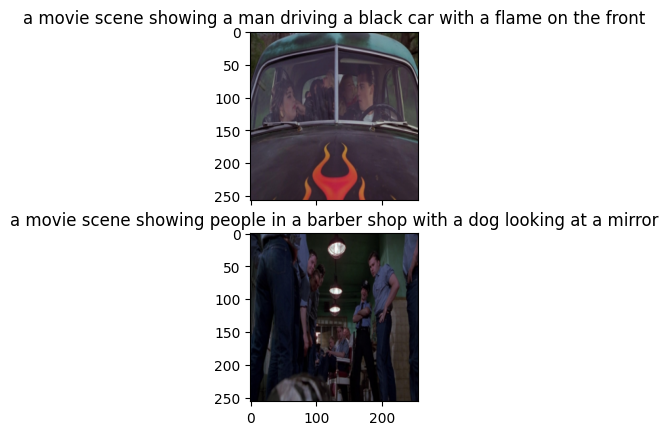

In [29]:
training_set = MovieclipDataset(
    patch_size=(256, 256), should_normalize=False, filters=[filter_on_genre("Adult")]
)
validation_set = MovieclipDataset(
    patch_size=(256, 256),
    should_normalize=False,
    is_validation=True,
    filters=[filter_on_genre("Adult")],
)

fig, axs = plt.subplots(2, 1, sharex=True)
image_tensor, caption = training_set[2]
# label_idx = torch.argmax(label_tensor)
image = to_pil_image(image_tensor)
axs[0].imshow(image)
axs[0].set_title(caption)

image_tensor, caption = validation_set[1]
image = to_pil_image(image_tensor)
# label_idx = torch.argmax(label_tensor)
axs[1].imshow(image)
axs[1].set_title(caption)

In [ ]:
training_dl = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
validation_dl = DataLoader(validation_set, batch_size=VAL_BATCH_SIZE)

## Model

We will be fine-tuning OpenAI's [openai/clip-vit-base-patch16](https://huggingface.co/openai/clip-vit-base-patch16) on the Movieclip dataset. Our requirements are 2 fold
- develop good zero-shot classification accuracy for sci-fi movies
- get customized image embeddings for the Moviesearch project.

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)

## Training Run


In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=BETAS,
    eps=EPS,
    weight_decay=WEIGHT_DECAY,
)
loss_img, loss_txt = nn.CrossEntropyLoss(), nn.CrossEntropyLoss()

In [30]:
def train(model, optimizer, loss_fn__txt, loss_fn__img, dataloader):
    print("Training")
    running_loss, running_correct = 0.0, 0

    # Set the model to training mode
    model.train()
    for _, data in enumerate(tqdm(dataloader, total=len(dataloader))):

        images, captions = data
        images, captions = images.to(device), captions.to(device)

        optimizer.zero_grad()

        # Forward pass
        logits_per_image, logits_per_text = model(images, captions)

        # Compute loss
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        total_loss = (
            loss_fn__img(logits_per_image, ground_truth)
            + loss_fn__txt(logits_per_text, ground_truth)
        ) / 2

        # Record the loss information
        running_loss += total_loss.item()
        # preds_idx, target_idx = preds.argmax(dim=1), target.argmax(dim=1)
        # running_correct += (preds_idx == target_idx).sum().item()

        total_loss.backward()
        optimizer.step()

    running_loss = running_loss / len(dataloader)
    running_correct = (100.0 * running_correct) / len(dataloader.dataset)
    return running_loss, running_correct

In [31]:
def validate(model, loss_fn, dataloader):
    print("Validation")

    running_loss, running_correct = 0.0, 0

    # Set the model to eval mode
    model.eval()
    with torch.no_grad():
        for _, data in enumerate(
            tqdm(dataloader, total=len(dataloader), position=0, leave=True)
        ):

            image, target = data
            image, target = image.to(device), target.to(device)
            preds = model(image)
            loss = loss_fn(preds, target)

            # Record the loss information
            running_loss += loss.item()
            preds_idx, target_idx = preds.argmax(dim=1), target.argmax(dim=1)
            running_correct += (preds_idx == target_idx).sum().item()

    running_loss = running_loss / len(dataloader)
    running_correct = (100.0 * running_correct) / len(dataloader.dataset)
    return running_loss, running_correct

In [ ]:
%%time

print("Starting Training...")

# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# start the training
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")

    train_epoch_loss, train_epoch_acc = train(model, optimizer, loss_fn, training_dl)
    valid_epoch_loss, valid_epoch_acc = validate(model, loss_fn, validation_dl)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(
        f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}"
    )
    print("-" * 50)
print("TRAINING COMPLETE")

In [ ]:
# Accuracy Plots
plt.figure(figsize=(10, 7))
plt.plot(train_acc, color="green", linestyle="-", label="train accuracy")
plt.plot(valid_acc, color="blue", linestyle="-", label="validataion accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color="orange", linestyle="-", label="train loss")
plt.plot(valid_loss, color="red", linestyle="-", label="validataion loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Save the final model
save_path = "model.pth"
torch.save(model.state_dict(), save_path)
print("MODEL SAVED...")